In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lvgp_bayes.models import LVGPR # main model class
from lvgp_bayes.optim import fit_model_scipy, run_hmc_numpyro # estimation functions

from lvgp_bayes.utils.variables import NumericalVariable,CategoricalVariable
from lvgp_bayes.utils.input_space import InputSpace

# metrics
from lvgp_bayes.utils.metrics import rrmse,mean_interval_score,coverage
from lvgp_bayes.utils.metrics import gaussian_mean_confidence_interval

from copy import deepcopy


# enable double precision floating points in jax for mcmc
import jax
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update(**{'figure.dpi':150})

## Read in the data and setup utility objects

In [2]:
# need xlrd
dat = pd.read_excel('../tests/m2ax/M2AX_data.xls')
dat

,M-site element,A-site element,X-site element,M-atom p-orbital radii,M-atom d-orbital radii,M-atom s-orbital radii,A-atom s-orbital radii,A-atom p-orbital radii,X-atom s-orbital radii,X-atom p-orbital radii,B (Bulk modulus),G (Shear modulus),E (Young's modulus)
0,Sc,Cd,C,0.500,0.539,1.570,0.445,1.1840,0.620,0.5960,73,36,92
1,Sc,Tl,C,0.500,0.539,1.570,1.060,1.3190,0.620,0.5960,84,55,135
2,Sc,In,C,0.500,0.539,1.570,1.093,1.3820,0.620,0.5960,86,54,135
3,Sc,Pb,C,0.500,0.539,1.570,1.010,1.2150,0.620,0.5960,87,58,142
4,Sc,Al,C,0.500,0.539,1.570,1.044,1.3120,0.620,0.5960,88,57,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,W,P,C,0.582,0.746,1.360,0.803,0.9175,0.620,0.5960,242,45,126
219,Ta,P,C,0.599,0.784,1.413,0.803,0.9175,0.620,0.5960,243,151,375
220,Ta,S,N,0.599,0.784,1.413,0.723,0.8080,0.521,0.4875,246,109,285
221,W,Si,C,0.582,0.746,1.360,0.904,1.0680,0.620,0.5960,251,95,253


We now create the `InputSpace` utility object to 

1. transform the data into the required format for modeling 
    - a numerical input must be scaled to [0,1]  (with/without log transform).
    - a categorical input variable with L levels must be encoded as integers 0,...,L-1. 
2. generate indices
    - the attribute `.quant_index` is a list of (column) indices for numerical or binary categorical inputs
    - the attribute `.qual_index` is a list of (column) indices for non-binary categorical inputs

In [3]:
config = InputSpace()
col_names = ['%s-site element'%l for l in ['M','A','X']]
elems = [
    CategoricalVariable(name=name,levels=dat[name].unique()) \
    for name in col_names
]
config.add_inputs(elems)

config

Input space with variables:

M-site element, Type: Categorical, Levels: {Sc, Zr, Nb, Cr, Ti, Hf, V, W, Ta, Mo}
A-site element, Type: Categorical, Levels: {Cd, Tl, In, Pb, Al, Ga, Sn, Ge, Si, As, P, S}
X-site element, Type: Categorical, Levels: {C, N}

In [4]:
# M and A will be treated as qualitative variables
config.qual_index

[0, 1]

In [5]:
# Since X has only two levels, it will be treated as a binary numerical variable
config.quant_index

[2]

In [6]:
# convert data into suitable format for modeling - torch tensor
# categorical variables - encoded as integers 0,1,...,L-1
all_x = torch.from_numpy(np.array([
    config.get_array_from_dict(row) for _,row in dat[config.get_variable_names()].iterrows()
]))

# response - Shear modulus
target = "G (Shear modulus)"
all_responses = torch.tensor(dat[target]).double()

print(all_x)

tensor([[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  2.,  0.],
        [ 0.,  3.,  0.],
        [ 0.,  4.,  0.],
        [ 0.,  5.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  6.,  0.],
        [ 0.,  3.,  1.],
        [ 0.,  2.,  1.],
        [ 0.,  1.,  1.],
        [ 0.,  7.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  8.,  0.],
        [ 0.,  4.,  1.],
        [ 0.,  5.,  1.],
        [ 0.,  6.,  1.],
        [ 2.,  1.,  1.],
        [ 0.,  9.,  0.],
        [ 3.,  1.,  0.],
        [ 4.,  0.,  0.],
        [ 1.,  3.,  0.],
        [ 1.,  1.,  0.],
        [ 5.,  0.,  0.],
        [ 1.,  2.,  0.],
        [ 4.,  3.,  0.],
        [ 6.,  1.,  0.],
        [ 6.,  0.,  0.],
        [ 0., 10.,  0.],
        [ 1.,  0.,  1.],
        [ 4.,  3.,  1.],
        [ 0.,  7.,  1.],
        [ 6.,  3.,  1.],
        [ 3.,  3.,  1.],
        [ 6.,  3.,  0.],
        [ 1.,  4.,  0.],
        [ 4.,  1.,  0.],
        [ 7.,  3.,  1.],
        [ 5.,  3.,  0.],
        [ 0., 11.,  0.],


In [7]:
def set_seed(seed:int):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

## Generate training and test splits

In [8]:
seed = 175
num_samples = 100 # 100 training, 123 test
rng = np.random.RandomState(seed)
idxs_train = rng.choice(all_x.shape[0],num_samples,replace=False)
train_x = all_x[idxs_train,:]
train_y = all_responses[idxs_train]

idxs_test = np.array([idx for idx in np.arange(all_x.shape[0]) if idx not in idxs_train])
test_x = all_x[idxs_test,:]
test_y = all_responses[idxs_test]

## Point estimation - Maximum a-posteriori (MAP)

We begin by defining the `LVGPR` instance. The required input arguments are the training data (`train_x` and `train_y`), the indices for the qualitative (`qual_index`) and quantitative (`quant_index`) variables, and the number of levels for each qualitative variable (`num_levels_per_var`), whose entries are specified in the same as order as that in the index list. The `InputSpace` object automatically generates the latter three entries.


To estimate a model through MAP method, use the `fit_model_scipy` method. All hyperparameters are jointly optimized using multi-start numerical optimization with **L-BFGS** as the optimization algorithm.

In [9]:
%%time 
set_seed(seed)
model = LVGPR(
    train_x=train_x,
    train_y=train_y,
    quant_correlation_class='RBFKernel',
    qual_index=config.qual_index,
    quant_index=config.quant_index,
    num_levels_per_var=list(config.num_levels.values()),
).double()


_ = fit_model_scipy(
    model, num_restarts=15,options={'ftol':1e-6,'maxfun':1000}
)

CPU times: user 26.2 s, sys: 590 ms, total: 26.8 s
Wall time: 26.6 s


In [10]:
# generate predictions
with torch.no_grad():
    # set return_std = False if standard deviation is not needed 
    test_pred,test_pred_std = model.predict(test_x,return_std=True)
    
# print RRMSE
lq,uq = test_pred-1.96*test_pred_std,test_pred+1.96*test_pred_std
stats_map = {
    'rrmse':rrmse(test_y,test_pred).item(),
    'mis':mean_interval_score(test_y,lq,uq,0.05).item(),
    'coverage':coverage(test_y,lq,uq).item(),
}
stats_map

{'rrmse': 0.7376690573631074,
 'mis': 278.5414957488564,
 'coverage': 0.3333333432674408}

In [11]:
## latent variables
with torch.no_grad():
    lvs_list = [layer.latents.detach().numpy() for layer in model.lv_mapping_layers]
    
lvs_list

[array([[ 0.        ,  0.        ],
        [ 1.63664078,  0.        ],
        [ 2.15056897, -0.73046038],
        [ 0.33814239, -1.21264979],
        [ 1.05894061, -0.26669733],
        [ 1.38742418, -0.16545754],
        [ 0.98575951, -1.39523248],
        [ 0.77302044, -2.01457111],
        [ 1.85697586, -0.97208636],
        [ 0.86524592,  0.1325861 ]]),
 array([[ 0.        ,  0.        ],
        [-0.70201589,  0.        ],
        [-0.56883643,  0.45631759],
        [-1.13458211, -0.03334601],
        [-0.28933773,  1.00300648],
        [-0.17998429,  1.09732637],
        [-1.08595977,  0.20904649],
        [-0.29011203,  0.61052602],
        [-0.42545129,  0.82317598],
        [-1.70124142,  1.34660288],
        [-1.38884147,  1.19431678],
        [ 0.05133772,  1.80813465]])]

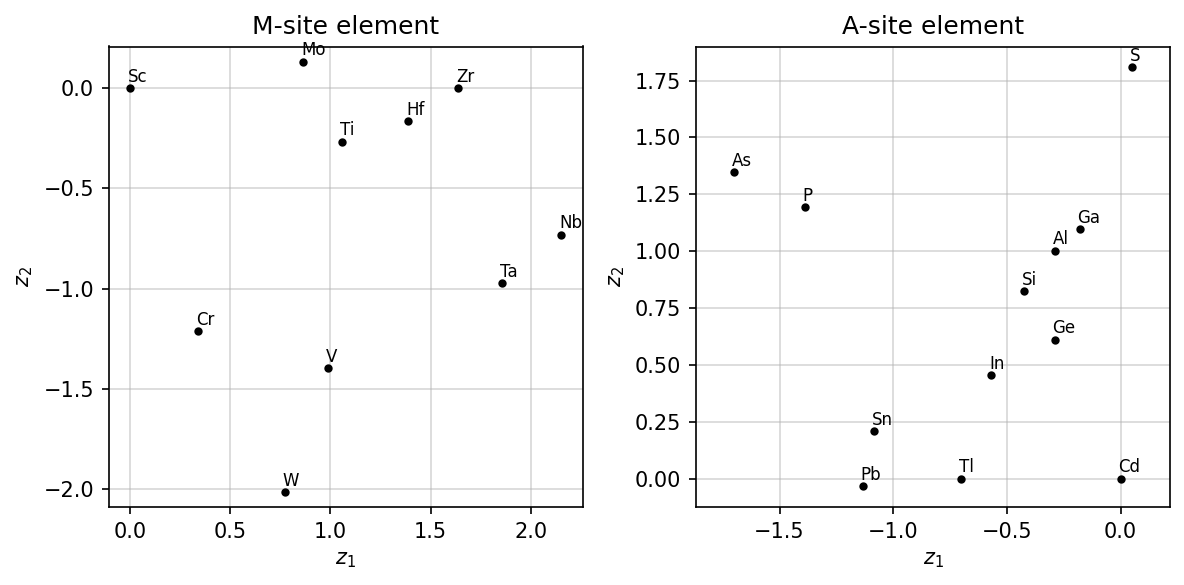

In [12]:
# plot latent values
fig,axs = plt.subplots(1,2,figsize=(8,4))

for i in range(2):
    latents = lvs_list[i]
    _ = axs[i].plot(latents[:,0],latents[:,1],'k.')
    
    cat = config.get_variable_by_idx(config.qual_index[i])
    # annotate the labels
    for j,level in enumerate(cat.levels):
        _ = axs[i].annotate(
            str(level),latents[j,:],
            textcoords = 'offset points',
            xytext = (-1,3),
            size='8'
        )
        
    
    _ = axs[i].set_xlabel(r'$z_1$')
    _ = axs[i].set_ylabel(r'$z_2$')
    _ = axs[i].set_title(cat.name)
    _ = axs[i].grid(alpha=0.5)
    _ = axs[i].set_aspect('equal', 'datalim')

fig.tight_layout()

## Fully Bayesian inference

For fully Bayesian inference, use the function `run_hmc_numpyro`. MCMC estimation usuaully takes longer than MAP estimation, but the resulting models tend to have better prediction accuracy and better quality of uncertainty quantification.

**Note**: 
1. MCMC is run with JAX as the backend and not PyTorch
2. The MCMC algorithm run can be unstable with single precision floating points, which is the default on JAX. We need to enable double precision floating points using `jax.config.update("jax_enable_x64", True)` (done earlier in the notebook). 

In [13]:
_ = model.train()
mcmc_runs = run_hmc_numpyro(
    model,
    num_samples=1500,warmup_steps=1500,
    max_tree_depth=7,
    disable_progbar=False,
    num_chains=1,
    num_model_samples=100, # final number of samples to store, obtained via thinning
    seed=seed
)

sample: 100%|█| 3000/3000 [03:37<00:00, 13.78it/s, 63 steps of size 3.82e-02. ac


In [14]:
# check diagnostics
# primary - rhat: closer to 1, the better, anything over 1.2 suggest some convergence issues
# n_eff: effective number of independent samples, - the higher the better
# Number of divergences: ideally none, but lower the better
mcmc_runs.print_summary()


                                                             mean       std    median      5.0%     95.0%     n_eff     r_hat
covar_module.base_kernel.kernels.1.raw_lengthscale[0,0]      0.42      0.44      0.36     -0.27      1.05    204.12      1.00
                           covar_module.raw_outputscale      0.53      0.48      0.49     -0.20      1.32    320.10      1.00
                    likelihood.noise_covar.raw_noise[0]     -3.23      1.17     -3.23     -4.85     -1.21    104.13      1.00
                   lv_mapping_layers.0.raw_latents[0,0]      0.13      1.46      0.27     -2.11      2.40    217.25      1.01
                   lv_mapping_layers.0.raw_latents[0,1]      0.12      1.42      0.20     -2.07      2.28    290.37      1.00
                   lv_mapping_layers.0.raw_latents[1,0]      0.05      0.92      0.07     -1.50      1.51    254.67      1.00
                   lv_mapping_layers.0.raw_latents[1,1]      0.05      0.91      0.06     -1.37      1.57    269.07  

In [15]:
with torch.no_grad():
    means,stds= model.predict(test_x.double(),return_std=True)

# predictions are now a matrix of size number of mcmc_samples x number of test observsation
means.shape

torch.Size([100, 123])

In [16]:
# to obtain predictions, average/marginalize over all the mcmc samples,
test_pred_mcmc = means.mean(axis=0)

# to obtain an estimate for the prediction standard deviations, marginalize over the mcmc samples
# this is NOT the same as an average
test_std_mcmc = torch.sqrt( torch.mean(stds**2,axis=0) + torch.var(means,axis=0))

In [17]:
# the posterior distribution is not Gaussian anymore but a mixture of Gaussians
# however, it is easy to estimate quantiles via simulation
lq,uq = gaussian_mean_confidence_interval(means,stds)
{
    'rrmse':rrmse(test_y,means.mean(axis=0)).item(),
    'mis':mean_interval_score(test_y,lq,uq,0.05).item(),
    'cov':coverage(test_y,lq,uq).item()
}

{'rrmse': 0.5377073200875621,
 'mis': 73.56603392559643,
 'cov': 0.9268292784690857}

A small drawback with MCMC inference is that interpreting the LV space is not as straightforward anymore. In particular, the LV space corresponding to each sample can result in different interpretations. We show 6 such samples for the M-site. 

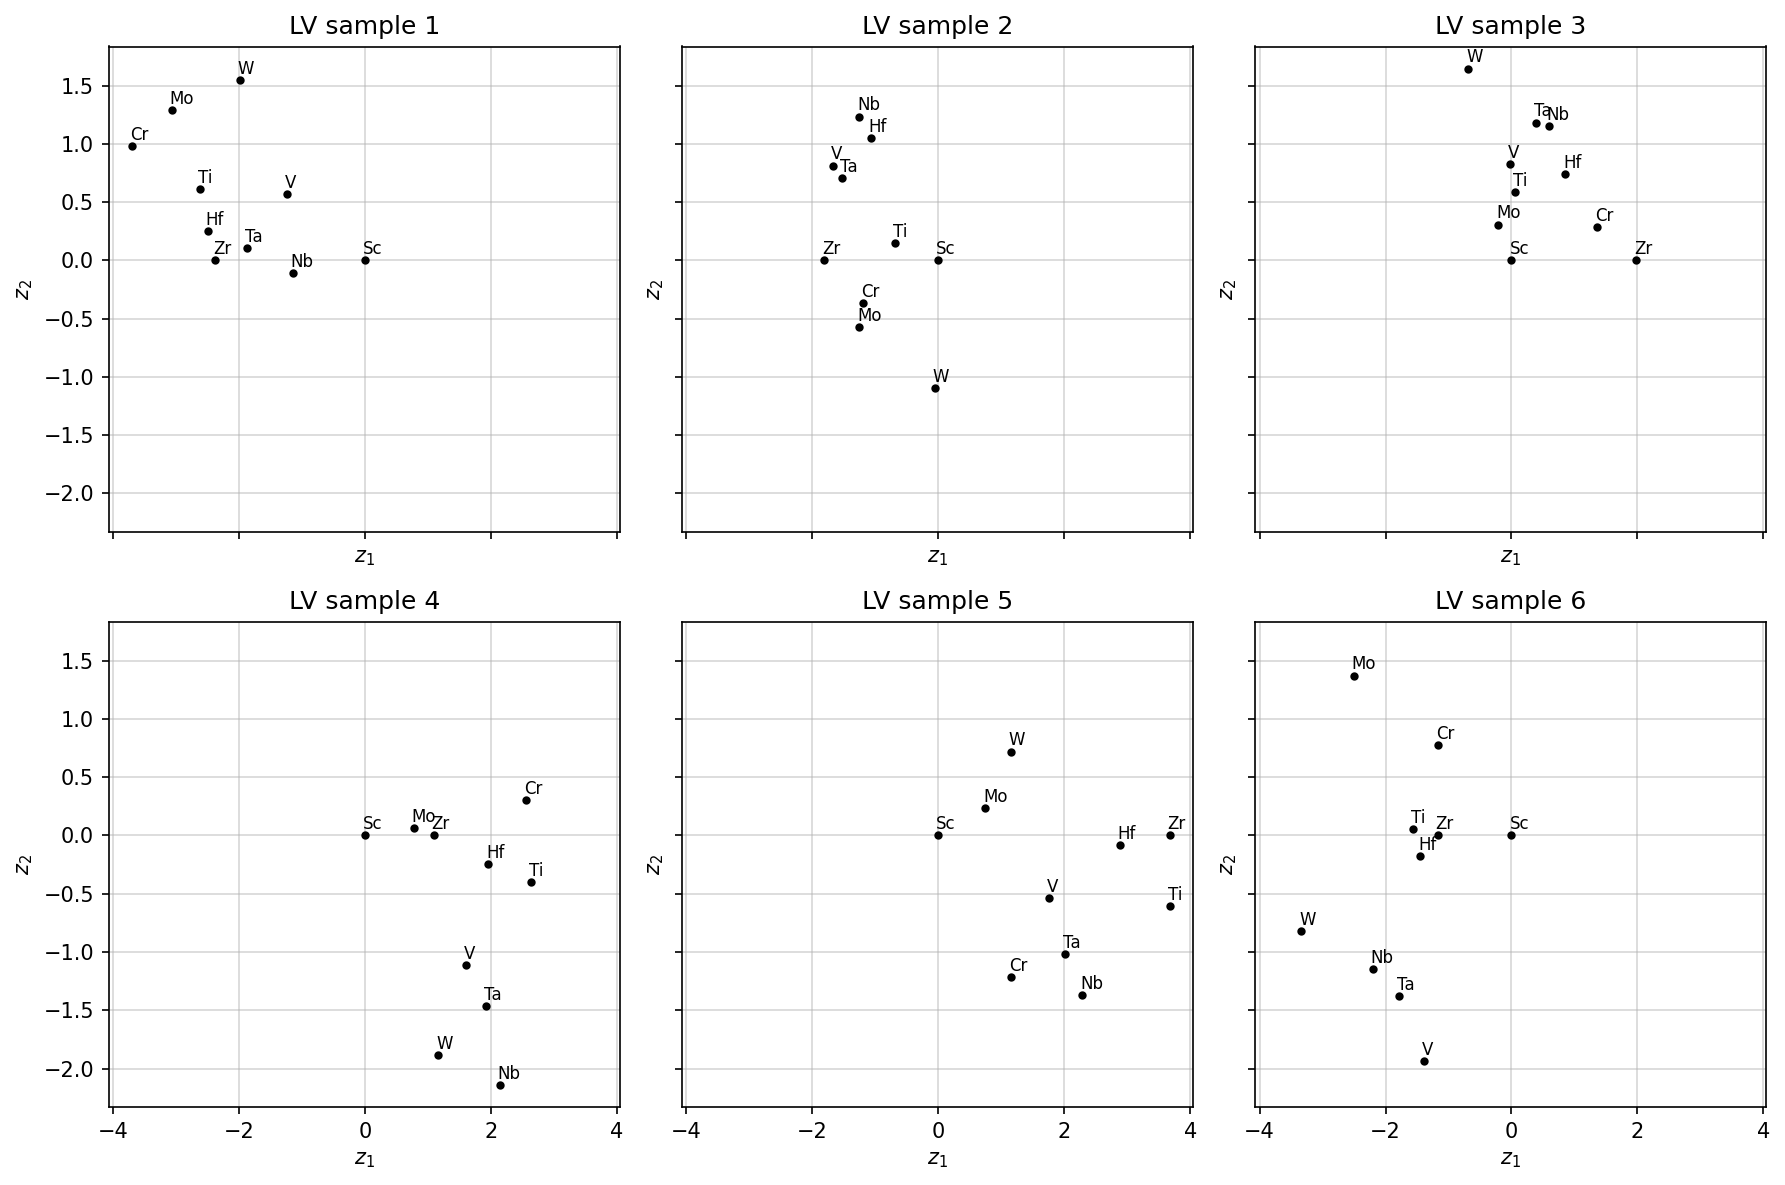

In [18]:
# plot for the different lv spaces for the M-site 
# each corresponding to a different MCMC sample
col_idx = 0
cat = config.get_variable_by_idx(config.qual_index[col_idx])
with torch.no_grad():
    m_site_lvs = model.lv_mapping_layers[col_idx].latents.detach()

# plot latent values
fig,axs = plt.subplots(2,3,figsize=(12,8),sharex=True,sharey=True)

for i in range(2):
    for j in range(3):
        idx = 3*i+j
        latents = m_site_lvs[idx,...]
        _ = axs[i,j].plot(latents[:,0],latents[:,1],'k.')

        
        # annotate the labels
        for k,level in enumerate(cat.levels):
            _ = axs[i,j].annotate(
                str(level),latents[k,:],
                textcoords = 'offset points',
                xytext = (-1,3),
                size='8'
            )


        _ = axs[i,j].set_xlabel(r'$z_1$')
        _ = axs[i,j].set_ylabel(r'$z_2$')
        _ = axs[i,j].set_title('LV sample %d'%(idx+1))
        _ = axs[i,j].grid(alpha=0.5)
        #_ = axs[i,].set_aspect('equal', 'datalim')

    fig.tight_layout()

A solution is to construct a representative LV space that reconciles differences across all MCMC samples. 

In [19]:
from lvgp_bayes.utils.bayesianlatents import LatentEmbeddingsObj
from lvgp_bayes.kernels import RBFKernel

In [20]:
base_kernel = RBFKernel()
base_kernel.raw_lengthscale.requires_grad_(False)
base_kernel.initialize(**{'lengthscale':1.})

m_site_le_obj = LatentEmbeddingsObj(
    latents=m_site_lvs,
    base_kernel = base_kernel,
    num_starts=20
)

m_site_rep = m_site_le_obj.run()

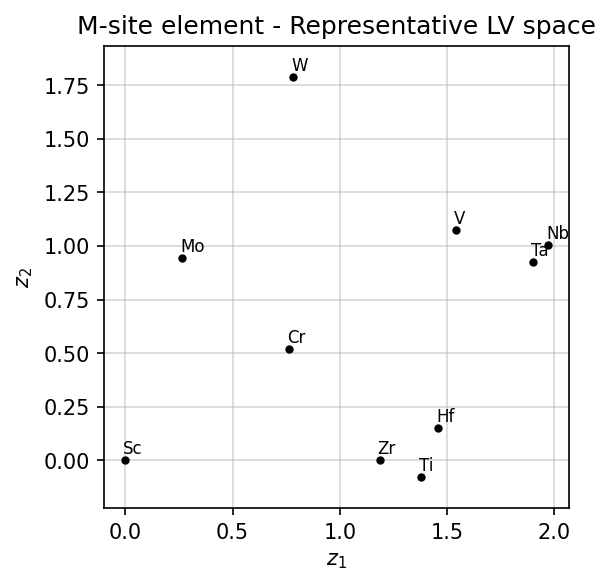

In [21]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

_ = ax.plot(m_site_rep[:,0],m_site_rep[:,1],'k.')
for j,level in enumerate(cat.levels):
    _ = ax.annotate(
        str(level),m_site_rep[j,:],
        textcoords = 'offset points',
        xytext = (-1,3),
        size='8'
    )


_ = ax.set_xlabel(r'$z_1$')
_ = ax.set_ylabel(r'$z_2$')
_ = ax.set_title(cat.name + ' - Representative LV space')
_ = ax.grid(alpha=0.5)
_ = ax.set_aspect('equal', 'datalim')


There are some differences with the LV space obtained through MAP. Some levels are closer here (e.g: Ta-Nb, V-Nb, Mo-Cr, Sc-Cr), while other are farther apart (e.g.: Mo-Zr, Cr-V, etc.).